## 实验：轮廓层次矩阵

### 实验概要

#### 轮廓检测和边缘检测的区别

你可能会想，如果检测都是针对轮廓的，那么轮廓检测不就和边缘检测一样了吗？

不完全是。至少对于强度有细微变化的图像来说不是这样。根据与 OpenCV 相关的文档，`轮廓` 是物体的边界，而 `边缘` 本质上是图像强度有显著变化的部分。例如，一个物体表面有许多不同颜色的阴影，那么它的表面就会有许多不同的 `边缘`。但由于它是一个物体，沿其形状（也就是 `轮廓`）只有一个。例如，在下面的图片中，仔细看看香蕉的表面:

![](./img/10.jfif)

香蕉皮表颜色的强度变化很大。轮廓检测将只给出主要目标的(封闭的)边界，而边缘检测将给出所有检测到的强度发生变化的区域。轮廓检测结果如下:

![](./img/11.jfif)

而边缘检测的结果如下:

<img src="./img/12.jfif" width="50%">

香蕉的边缘检测标记了图像中所有发生强度变化的区域。而轮廓检测则是根据生成的二值图像给出形状的轮廓。如果您在执行图像二值化转换时，使用不同的阈值，您将得到不同的二值图像，从而得到不同的轮廓集。您可能会注意到，与边缘不同，轮廓始终是一个封闭的形状。在OpenCV 中，边缘检测可以直接应用于RGB 图像 / 灰度图像 / 二值图像，而轮廓检测仅适用于二值图像。

#### 轮廓的层次结构

轮廓可以被相互关联。一个轮廓可能位于另一个更大的轮廓以内，那么它就是这个更大的轮廓的子轮廓。同样，一个轮廓甚至可能有孙轮廓和曾孙轮廓。这些叫做嵌套轮廓。让我们来看看下面的图像:

<img src="./img/13.jfif" width="50%">

你看到多少轮廓？1，2 还是 3？

答案是 `3`。前面提及，轮廓是白色物体在黑色背景上的边界。前面的图像有一个空心的正方形和一个填充的圆形。你可以确定填充的圆是一个单一的圆点;然而，你可能会与空心正方形混淆。空心正方形有两个轮廓：外边框和内边框；在正方形上画出两条白色的边界和两个轮廓。这使得整个图像中总共有三个轮廓：

<img src="./img/14.jfif" width="50%">

要访问层次结构信息，您需要根据需求设置 `cv2.findContours` 的 `retrieveing_mode` 输入。

在本章开始学习 `cv2.findContours` 命令时，您会看到用于设置轮廓检索模式的不同输入选项

- `RETR_EXTERNAL`
- `RETR_LIST`
- `RETR_CCOMP`
- `RETR_TREE`

看一下它对应的输出变量：`hierarchy`。 查看任何样本图像的层次结构变量的值，都会注意到它是一个矩阵，其中有多少行，就等于检测到多少个轮廓。考虑以下轮廓检索命令和层次结构：

<img src="./img/15.jfif">

每行包含有关单个轮廓的信息。 如上图所示，每一行包含四列，下面详细解析一下每一列的意义：

- 第 1 列：包含其下一个轮廓的数字 ID，该轮廓在相同的层次结构级别上。如果不存在这样的轮廓，则其值在此处列出为 -1。
- 第 2 列：包含其上一个轮廓的数字 ID，该 ID 在相同的层次结构级别上。如果不存在这样的轮廓，则其值在此处列出为 -1。
- 第 3 列：包含其下一个层次结构/第一个子轮廓的数字 ID。如果不存在这样的轮廓，则其值在此处列出为 -1。
- 第 4 列：包含其父轮廓的数字 ID，该 ID 在下一个层次级别。如果不存在这样的轮廓，则其值在此处列出为 -1。

现在，让我们在示例图像上使用这些选项，看看会有什么区别。

### 实验目标

本实验将根据以下图像，通过应用不同的轮廓层次结构参数，绘制出对应的轮廓，并输出层次结构矩阵，基于轮廓层次矩阵尝试解释轮廓间的层次关系。

<img src="./img/13.jfif" width="50%">

### 1. 导入依赖库

In [1]:
import cv2                        # 导入OpenCV
import matplotlib.pyplot as plt   # 导入matplotlib

# 魔法指令，使图像直接在Notebook中显示
%matplotlib inline
a = [1,2,3]
print(a*2)

[1, 2, 3, 1, 2, 3]


### 2. 加载图像并保存副本

保证对原始图像 `image` 进行的任何更改，都不会影响此副本 `imagecopy`。最后，我们可以在原始图像的副本 `imagecopy` 上绘制结果：

In [2]:
# 设置输入输出路径
import os
base_path = os.environ.get("BASE_PATH",'../data/')
data_path = os.path.join(base_path + "lab4/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)

# 读取图像文件
image = cv2.imread('./data/contour_hierarchy.png')           
# 拷贝保存副本
imagecopy= image.copy()                                      

### 3. 显示图像

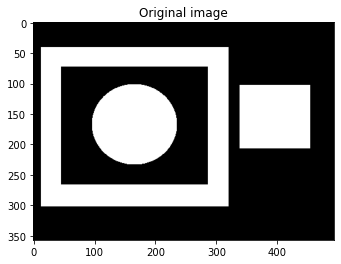

In [4]:
# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow('Original image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(image[:,:,::-1])        # 将图像从 BGR 转换为 RGB
plt.title('Original image')        # 指定输出图像的标题
plt.show()                         # 显示图像

上面的图像是以三通道格式保存的。尽管此黑白图像看起来像二进制图像，但实际上，它是三通道 BGR 图像。要对其应用轮廓检测，需要将其转换为实际的单通道二值图像 —— 同时，只有灰度图像可以转换为二值图像。

### 4. 转换灰度图像

首先，需要使用以下代码将图像转换为灰度图像:

In [12]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 灰度读入 单通道读入
gray_image = cv2.imread('./data/contour_hierarchy.png',0)
print(gray_image)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


另外，在 OpenCV 中，您还可以使用 `im = cv2.imread (filename, cv2.IMREAD_GRAYSCALE)` 命令直接以灰度级读取 BGR 图像。同时，`im = cv2.imread (filename，0)` 命令将产生相同的结果。

### 5. 图像二值化

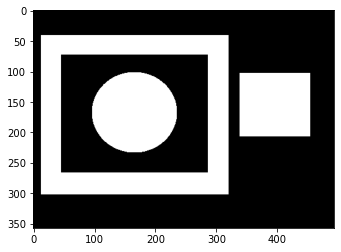

In [13]:
# 直接输入阈值与最大值，执行图像二值化
ret, im_binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY) 

plt.imshow(im_binary, cmap='gray') # 使用灰色“喷涂”图像输出显示
plt.show()                         # 显示图像

由于当前图像已经是黑色背景，需要检测的轮廓为白色，因此无需进行反转图像，直接执行轮廓检测与绘制。

### 6.1 轮廓检测并输出层次矩阵 - cv2.RETR_EXTERNAL

根据以下代码输出可以得证：

<img src="./img/16.png">

对于 `cv2.RETR_EXTERNAL`，只有两个检测到的轮廓，所有内部轮廓都将被忽略。

1. 第一行对应于轮廓 0。其下一个轮廓为 1。其上一个轮廓不存在（-1）。由于仅考虑外部轮廓，因此其子轮廓和父轮廓也不适用（-1 和 -1）。
2. 第二行对应于轮廓 1。由于该图像中没有其他轮廓，因此它的下一个轮廓不存在（-1）。 其先前的轮廓为轮廓 0。其子轮廓和父轮廓不存在（最后两列中为 -1 和 -1）。

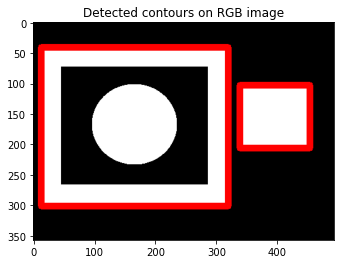

In [14]:
# 使用cv2.RETR_EXTERNAL参数执行轮廓检测
contours,hierarchy = cv2.findContours(im_binary,
                    cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 

# 在之前复制的副本图像上标记所有检测到的轮廓，用红色（0,0,255） 绘制，将厚度设置为 10:
with_contours = cv2.drawContours(imagecopy, contours, -1,(0,0,255),10) 

# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'Detected contours on RGB image' , with_contours )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

# 使用matplotlib将图像转换为RGB
plt.imshow(with_contours[:,:,::-1])          
# 指定输出图像的标题
plt.title('Detected contours on RGB image')  
# 显示图像
plt.show()                                   

In [15]:
print(len(contours))    # 输出检测到的轮廓数量
print(hierarchy);       # 输出轮廓层次矩阵

2
[[[ 1 -1 -1 -1]
  [-1  0 -1 -1]]]


### 6.2 轮廓检测并输出层次矩阵 - cv2.RETR_LIST

根据以下代码输出可以得证：

<img src="./img/17.png">

对于 `cv2.RETR_LIST`，有 4 个检测到的轮廓。所有内部轮廓均被“独立”检测。这里的“独立”是指没有形成亲子关系（最后两列为 -1）。这意味着所有轮廓都被视为处于同一层次级别。 此图像中总共有 4 个轮廓（因为存在 4 行）。 

1. 第一行对应于轮廓 0。其后为轮廓 1，而前没有轮廓 (-1)。
2. 第二行对应于轮廓 1。其后为轮廓 2，其前为轮廓 0。 
3. 第三行对应于轮廓 2。其后为轮廓 3，其前为轮廓 1。 
4. 第四行对应于轮廓 3。其后没有轮廓（因为没有更多的轮廓了 -1），其前为轮廓 2。

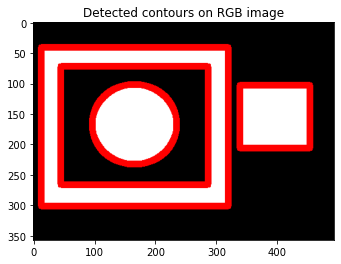

In [16]:
# 使用cv2.RETR_LIST参数执行轮廓检测
contours,hierarchy = cv2.findContours(im_binary,
                        cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) 

# 在之前复制的副本图像上标记所有检测到的轮廓，用红色（0,0,255） 绘制，将厚度设置为 10:
with_contours = cv2.drawContours(imagecopy, contours, -1,(0,0,255),10) 

# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'Detected contours on RGB image' , with_contours )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

# 使用matplotlib将图像转换为RGB
plt.imshow(with_contours[:,:,::-1])          
# 指定输出图像的标题
plt.title('Detected contours on RGB image')  
# 显示图像
plt.show()                                   

In [17]:
print(len(contours))    # 输出检测到的轮廓数量
print(hierarchy);       # 输出轮廓层次矩阵

4
[[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [-1  2 -1 -1]]]


### 6.3 轮廓检测并输出层次矩阵 - cv2.RETR_CCOMP

根据以下代码输出可以得证：

<img src="./img/18.png">

对于 `RETR_CCOMP`，只有两个层次级别。对象的外部边界在一个级别上，内部边界在另一个级别上。在这里尝试理解此层次结构矩阵，因为它不像前两个简单。

- 我们知道，只有一个外部边界（没有内部空间）的轮廓没有父级也没有子级。因此，此轮廓的最后两列应为 -1。这里的前两行在其后两列中都为 -1，从这一点，可以得出结论，前两行分别对应于：实心矩形形和实心圆。
- 我们还知道，前两列在同一层次上给出了下一个和上一个轮廓的索引。如果在同一水平上没有其他轮廓，则这两个值应为 -1。看最后一行。它必须属于空心矩形的内部边界，因为在该层上没有其他轮廓（即，没有其他内孔边界）。
- 剩下第 3 行和空心矩形的外边界轮廓。因此，第 3 行正式代表此轮廓。这个轮廓有一个子轮廓（即：最后一行，空心矩形的内部边界），但没有父轮廓，因此对于这个轮廓，会有一个子但没有父轮廓，这反映在第 3 行的最后两列中。

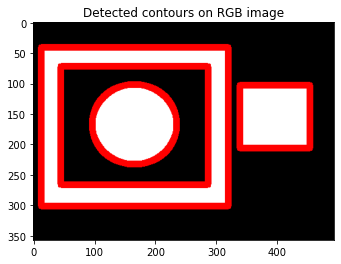

In [18]:
# 使用cv2.RETR_CCOMP参数执行轮廓检测
contours,hierarchy = cv2.findContours(im_binary,
                        cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE) 

# 在之前复制的副本图像上标记所有检测到的轮廓，用红色（0,0,255） 绘制，将厚度设置为 10:
with_contours = cv2.drawContours(imagecopy, contours, -1,(0,0,255),10) 

# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'Detected contours on RGB image' , with_contours )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

# 使用matplotlib将图像转换为RGB
plt.imshow(with_contours[:,:,::-1])          
# 指定输出图像的标题
plt.title('Detected contours on RGB image')  
# 显示图像
plt.show()                                   

In [19]:
print(len(contours))    # 输出检测到的轮廓数量
print(hierarchy);       # 输出轮廓层次矩阵

4
[[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [-1  1  3 -1]
  [-1 -1 -1  2]]]


### 6.4 轮廓检测并输出层次矩阵 - cv2.RETR_TREE

根据以下代码输出可以得证：

<img src="./img/19.png">

对于 `cv2.RETR_TREE`，查看其层次结构矩阵。

1. 第一行，它的最后两列的值分别为 -1 和 -1，因此它是一个没有子级也没有父级的轮廓。查看该图，我们可以轻松得出结论，它是实心矩形的轮廓。
2. 第二行，该轮廓有一个子轮廓但没有父轮廓。因此，它是空心矩形形的外边界。 
3. 第三行，该轮廓有一个子轮廓和一个父轮廓。因此，它是空心矩形孔的内边界。 
4. 第四行，该轮廓没有子轮廓，只有一个父轮廓。 因此，它里面必然没有轮廓，而外面必然有轮廓。一定是中间的实心圆。

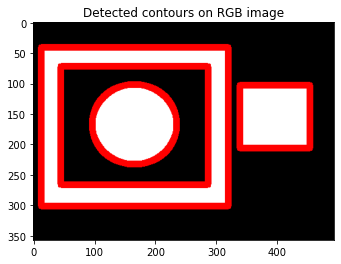

In [20]:
# 使用cv2.RETR_TREE参数执行轮廓检测
contours,hierarchy = cv2.findContours(im_binary,
                        cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

# 在之前复制的副本图像上标记所有检测到的轮廓，用红色（0,0,255） 绘制，将厚度设置为 10:
with_contours = cv2.drawContours(imagecopy, contours, -1,(0,0,255),10) 

# 在云实验环境下忽略以下代码，避免程序尝试打开系统窗口显示图片；
# 使用matplotlib替换，使图像直接在 Jupyter Notebook 中输出。

# cv2.imshow( 'Detected contours on RGB image' , with_contours )
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

# 使用matplotlib将图像转换为RGB
plt.imshow(with_contours[:,:,::-1])          
# 指定输出图像的标题
plt.title('Detected contours on RGB image')  
# 显示图像
plt.show()                                   

In [21]:
print(len(contours))    # 输出检测到的轮廓数量
print(hierarchy);       # 输出轮廓层次矩阵

4
[[[ 1 -1 -1 -1]
  [-1  0  2 -1]
  [-1 -1  3  1]
  [-1 -1 -1  2]]]


### 实验小结

在本实验中，您通过应用不同的轮廓层次结构参数，绘制出对应的轮廓。同时，透过轮廓层次矩阵，了解轮廓间的层次关系。